# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Matemática Para Data Science</font>

## <font color='blue'>Mini-Projeto 2</font>
### <font color='blue'>Matemática do Modelo Transformer na Análise e Forecast de Séries Temporais</font>

![title](imagens/MP2.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.18


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
#!pip install -q torch==2.0.1

In [4]:
#!pip install -q transformers==4.30.2

In [5]:
#!pip install -q datasets

In [6]:
#!pip install -q evaluate

In [7]:
#!pip install -q accelerate==0.20.3

In [8]:
#!pip install -q gluonts==0.13.2

In [9]:
#!pip install -q ujson

In [10]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [11]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [12]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [13]:
# Imports
import torch
import transformers
import accelerate
import gluonts
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import lru_cache
from functools import partial
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from transformers import PretrainedConfig
from typing import Optional
from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
from typing import Iterable
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches
from gluonts.time_feature import get_seasonality
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.transform.sampler import InstanceSampler
from gluonts.time_feature import (time_features_from_frequency_str, TimeFeature, get_lags_for_frequency)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

/Users/frnepom/.pyenv/versions/3.9.18/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas      : 2.1.4
numpy       : 1.26.3
transformers: 4.30.2
gluonts     : 0.13.2
matplotlib  : 3.8.2
torch       : 2.0.1
accelerate  : 0.20.3



## Carregando os Dados de Séries Temporais

https://huggingface.co/datasets/monash_tsf

In [15]:
dataset = load_dataset("monash_tsf", "tourism_monthly")

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [17]:
dataset['train']

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [18]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [19]:
train_example = dataset['train'][0]

In [20]:
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [21]:
print(train_example['start'])
print(train_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [22]:
validation_example = dataset['validation'][0]

In [23]:
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [24]:
print(validation_example['start'])
print(validation_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

## Visualizando a Série Temporal

In [25]:
# Frequência da série temporal (1 mês)
freq = "1M"

In [26]:
# Janela de previsão (24 meses)
prediction_length = 24

In [27]:
# Verifica se o comprimento dos dados de testes permite a janela de previsão
assert len(train_example["target"]) + prediction_length == len(validation_example["target"])

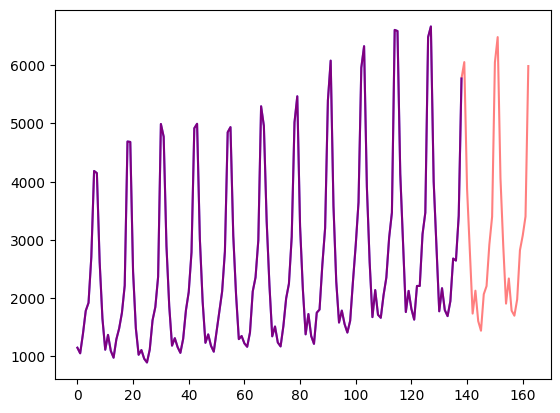

In [28]:
# Plot
figure, axes = plt.subplots()
axes.plot(train_example["target"], color = "blue")
axes.plot(validation_example["target"], color = "red", alpha = 0.5)
plt.show()

## Definição dos Atributos

In [29]:
# Datasets de treino e teste
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [30]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [31]:
# Função para converter para um período de data
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

In [32]:
# Função para definir o início do batch de dados
def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [33]:
# Ajusta os datasets das séries temporais no formato apropriado
train_dataset.set_transform(partial(transform_start_field, freq = freq))
test_dataset.set_transform(partial(transform_start_field, freq = freq))

In [34]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [35]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

"Lags" em séries temporais referem-se a pontos de dados anteriores em uma série de tempo. Em outras palavras, um "lag" é um atraso temporal. Por exemplo, em uma série temporal mensal, o "lag" de um mês refere-se aos dados do mês anterior.

Os "lags" são usados principalmente em modelos de séries temporais para entender os padrões de tempo nos dados. Em particular, os modelos autoregressivos (AR) usam "lags" dos dados de séries temporais como variáveis de entrada.

Por exemplo, um modelo AR(1) usa um "lag" de um período (por exemplo, o valor da série temporal no mês anterior) para prever o valor atual da série temporal. Um modelo AR(2) usaria dois "lags" (por exemplo, os valores da série temporal nos dois meses anteriores) para prever o valor atual.

De uma forma geral, a ideia de "lag" é essencial para muitas técnicas de análise de séries temporais e fornece um meio de incorporar informações históricas na previsão de dados futuros.

In [36]:
# Lags
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [37]:
# Atributos de tempo
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x2acb171f0>]


## TimeSeries Transformer Config

O código abaixo é para configurar um transformador de séries temporais. A configuração define vários hiperparâmetros para o modelo. Detalhes de cada parâmetro:

**prediction_length**: o número de etapas à frente que o modelo deve prever. Por exemplo, se você estiver trabalhando com dados diários e quiser prever uma semana à frente, o prediction_length seria 7.

**context_length**: o número de pontos de dados anteriores que o modelo usará para fazer suas previsões. Neste caso, é definido como duas vezes o prediction_length.

**lags_sequence**: esta é a sequência de atrasos de tempo (ou "lags") que o modelo usará. Lags são valores passados em uma série temporal. Por exemplo, em um modelo de regressão, você pode usar dados de um dia, uma semana e um mês atrás como entradas.

**num_time_features**: o número de características temporais que o modelo usará. Características de tempo podem incluir coisas como a hora do dia, dia da semana, mês do ano, etc.

**num_static_categorical_features**: o número de características categóricas estáticas. Essas são características que não mudam com o tempo, como o ID de uma loja ou produto em previsões de vendas.

**cardinality**: o número de valores possíveis para cada característica categórica. Aqui, há uma característica categórica com 366 valores possíveis.

**embedding_dimension**: a dimensionalidade do espaço de incorporação para as características categóricas. Neste caso, cada um dos 366 possíveis valores categóricos será mapeado para um vetor de 2 dimensões.

**encoder_layers e decoder_layers**: o número de camadas na codificador e decodificador do transformador, respectivamente.

**d_model**: a dimensionalidade do espaço de entrada e saída para o transformador.

Todos esses parâmetros serão usados para construir e treinar o modelo de transformador de séries temporais. A escolha desses hiperparâmetros pode ter um grande impacto na performance do seu modelo.

In [38]:
# TimeSeries Transformer Config
config = TimeSeriesTransformerConfig(
    
    prediction_length = prediction_length,
    
    # Comprimento do contexto
    context_length = prediction_length * 2,
    
    # Lags sequence
    lags_sequence = lags_sequence,
    
    # Adicionaremos 2 características de tempo ("mês do ano" e "idade", veja mais adiante):
    num_time_features =len(time_features) + 1,
    
    # Temos um único recurso categórico estático, ou seja, o ID da série temporal
    num_static_categorical_features = 1,
    
    # Tem 366 valores possíveis:
    cardinality = [len(train_dataset)],
    
    # O modelo aprenderá uma embedding de tamanho 2 para cada um dos 366 valores possíveis:
    embedding_dimension = [2],
    
    # Parâmetros da rede neural do Transformer
    encoder_layers = 4,
    decoder_layers = 4,
    d_model = 32,
)
    


## TimeSeries Transformer For Prediction

https://huggingface.co/docs/transformers/model_doc/time_series_transformer

Os Transformers são modelos de aprendizado de máquina baseados em atenção que foram introduzidos em 2017 no artigo <a href="https://arxiv.org/abs/1706.03762">"Attention is All You Need"</a> de Vaswani et al. Eles têm sido usados com sucesso em uma variedade de tarefas de processamento de linguagem natural, como tradução automática e geração de texto. A arquitetura do Transformer pode ser descrita em suas principais partes:

**Codificador**: O codificador consiste em uma pilha de camadas idênticas, cada uma com duas sub-camadas: uma sub-camada de atenção multi-cabeça e uma sub-camada de feed-forward. A saída de cada sub-camada passa por uma normalização de camada e é então usada como entrada para a próxima sub-camada. A entrada para o codificador é uma sequência de tokens, que são primeiro incorporados em vetores e então modificados por uma codificação posicional antes de serem alimentados no codificador.

**Atenção multi-cabeça**: A atenção multi-cabeça permite que o modelo se concentre em diferentes partes da entrada para cada cabeça de atenção. A atenção é calculada usando uma função softmax em um produto escalar de um vetor de consulta com todos os vetores-chave, e os resultados são usados para ponderar os vetores de valor. Isso é feito separadamente para cada cabeça de atenção, e então as saídas são concatenadas e linearmente transformadas para produzir a saída final da atenção multi-cabeça.

**Rede feed-forward**: A rede feed-forward que segue a atenção multi-cabeça em cada camada do codificador e decodificador é uma rede simples com duas camadas lineares e uma ativação ReLU entre elas.

**Decodificador**: O decodificador também consiste em uma pilha de camadas idênticas, mas com uma terceira sub-camada que realiza atenção multi-cabeça sobre a saída do codificador. Isso permite que o decodificador leve em consideração toda a sequência de entrada ao produzir cada token de saída.

**Camada final de classificação**: Finalmente, a saída do decodificador passa por uma camada linear e uma função softmax para produzir probabilidades para cada token possível na sequência de saída.

O modelo Transformer é treinado usando a otimização de descida de gradiente estocástica e a função de perda de entropia cruzada para as previsões de probabilidade de token.

### Matemática do Modelo Transformer

Vamos descrever as partes do modelo Transformer com algumas fórmulas. Os termos a seguir serão úteis para entender:

- Q: vetor de consulta
- K: vetor de chave
- V: vetor de valor

As fórmulas para o mecanismo de atenção no Transformer são as seguintes:

Atenção Escalada por Produto Escalar:

A função de atenção é usada para calcular a importância de diferentes partes da entrada. Ela recebe três entradas: Q, K e V. A saída é calculada como:

**Attention(Q, K, V) = softmax((QK^T) / sqrt(d_k))V**

onde d_k é a dimensão dos vetores-chave e o operador ^T indica a transposição de uma matriz. A operação de produto escalar entre Q e K ajuda a determinar a relevância entre cada par de consulta e chave. O resultado é então dividido pela raiz quadrada de d_k para evitar que os valores do produto escalar fiquem muito grandes. Por fim, a função softmax é aplicada para transformar os pesos em probabilidades que somam 1. Esses pesos são então usados para ponderar os vetores de valor.

Atenção Multi-cabeça:

A atenção multi-cabeça permite que o modelo se concentre em diferentes partes da entrada para cada cabeça de atenção. Suponha que temos h cabeças de atenção. Para cada cabeça, primeiro transformamos Q, K e V com diferentes pesos aprendidos:

- Q_i = QW^Q_i
- K_i = KW^K_i
- V_i = VW^V_i

onde W^Q_i, W^K_i e W^V_i são os pesos aprendidos para a i-ésima cabeça.

Em seguida, aplicamos a atenção escalada por produto escalar para cada conjunto de Q_i, K_i e V_i:

**head_i = Attention(Q_i, K_i, V_i)**

A saída de todas as cabeças é então concatenada e linearmente transformada para produzir a saída final:

**MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O**

onde W^O é uma matriz de pesos aprendida.

Codificador e Decodificador:

No codificador, cada camada consiste em atenção multi-cabeça seguida por uma rede neural feed-forward. A entrada passa pela atenção multi-cabeça e é então somada à entrada original (conexão residual) e normalizada. O resultado passa pela rede feed-forward, é somado à entrada e normalizado novamente.

No decodificador, temos uma camada adicional de atenção multi-cabeça que leva a saída do codificador como K e V. Isso permite que o decodificador leve em consideração a entrada inteira ao produzir cada token de saída.

In [39]:
# Cria o modelo com a config criada
model = TimeSeriesTransformerForPrediction(config)

## Pré-Processamento dos Dados

In [40]:
# Função para criar a transformação (sequência dos dados)
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    
    remove_field_names = []
    
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
        
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)
        
    return Chain(
        
        # Passo 1: remover campos estáticos/dinâmicos se não for especificado
        [RemoveFields(field_names = remove_field_names)]
        
        # Passo 2: converter os dados para NumPy (potencialmente não necessário)
        + (
            [
                AsNumpyArray(field = FieldName.FEAT_STATIC_CAT, expected_ndim = 1, dtype = int)
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(field = FieldName.FEAT_STATIC_REAL, expected_ndim = 1)
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(field=FieldName.TARGET, expected_ndim = 1 if config.input_size == 1 else 2,
            ),
        
            # Passo 3: Trata os NaN's preenchendo o alvo com zero e retornando a máscara
            AddObservedValuesIndicator(target_field = FieldName.TARGET, output_field = FieldName.OBSERVED_VALUES),
            
            # Passo 4: Adiciona recursos temporais com base na freq do mês do ano do conjunto de dados 
            # no caso em que freq="M" eles servem como codificações posicionais
            AddTimeFeatures(
                start_field = FieldName.START,
                target_field = FieldName.TARGET,
                output_field = FieldName.FEAT_TIME,
                time_features = time_features_from_frequency_str(freq),
                pred_length = config.prediction_length
            ),
            # Passo 5: Adiciona outro recurso temporal (apenas um único número) 
            # Informa ao modelo onde está o valor da série temporal, uma espécie de contador em execução
            AddAgeFeature(
                target_field = FieldName.TARGET,
                output_field = FieldName.FEAT_AGE,
                pred_length = config.prediction_length,
                log_scale = True,
            ),
            
            # Passo 6: Empilha verticalmente todos os recursos temporais na chave FEAT_TIME
            VstackFeatures(
                output_field = FieldName.FEAT_TIME,
                input_fields = [FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            
            # Passo 7: Renomeia para corresponder aos nomes HuggingFace
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )            
             
            
            

## Divisão nas Amostras de Treino, Validação e Teste

In [41]:
# Função para separar os dados em treino, validação e teste
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    
    assert mode in ["train","validation", "test"]
    
    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances = 1.0, min_future = config.prediction_length            
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future = config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]
    
    return InstanceSplitter(
        target_field = "values",
        is_pad_field = FieldName.IS_PAD,
        start_field = FieldName.START,
        forecast_start_field = FieldName.FORECAST_START,
        instance_sampler = instance_sampler,
        past_length = config.context_length + max(config.lags_sequence),
        future_length = config.prediction_length,
        time_series_fields = ["time_features", "observed_mask"],
    )
    

## Criação dos Dataloaders

In [73]:
# Função para criar o dataloader de treino
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train = True)
    
    if cache_data:
        transformed_data = Cached(transformed_data)

    # Inicializa a instância de treino
    instance_splitter = create_instance_splitter(config, "train")

    # O divisor de instância irá amostrar uma janela de comprimento de contexto + atrasos + comprimento de previsão 
    # (das 366 possíveis séries temporais transformadas) aleatoriamente de dentro da série temporal de destino 
    # e retornará um iterador.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train = True)
    
    return as_stacked_batches(
        training_instances,
        batch_size = batch_size,
        shuffle_buffer_length = shuffle_buffer_length,
        field_names = TRAINING_INPUT_NAMES,
        output_type = torch.tensor,
        num_batches_per_epoch = num_batches_per_epoch,
    )

In [74]:
# Função para criar o dataloader de teste
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")
        
    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")
        
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)
    
    # Criamos um divisor de instância de teste que irá amostrar a última janela de contexto vista durante 
    # o treinamento apenas para o codificador.
    instance_sampler = create_instance_splitter(config, "test")

    # Aplicamos as transformações em modo de teste
    testing_instances = instance_sampler.apply(transformed_data, is_train = False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size = batch_size,
        output_type = torch.tensor,
        field_names = PREDICTION_INPUT_NAMES,
    )
   

In [75]:
# Cria o dataloader de treino
train_dataloader = create_train_dataloader(
    config = config,
    freq = freq,
    data = train_dataset,
    batch_size = 256,
    num_batches_per_epoch = 100,
)

In [76]:
# Cria o dataloader de teste
test_dataloader = create_test_dataloader(
    config = config,
    freq = freq,
    data = test_dataset,
    batch_size = 64
)

In [77]:
# Imprime os itens de um batch para verificar se tudo está ok
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type)

past_time_features torch.Size([256, 85, 2]) <built-in method type of Tensor object at 0x2ace1d4f0>
past_values torch.Size([256, 85]) <built-in method type of Tensor object at 0x2ad95e180>
past_observed_mask torch.Size([256, 85]) <built-in method type of Tensor object at 0x2ad95e270>
future_time_features torch.Size([256, 24, 2]) <built-in method type of Tensor object at 0x2ad9413b0>
static_categorical_features torch.Size([256, 1]) <built-in method type of Tensor object at 0x2ad95c630>
future_values torch.Size([256, 24]) <built-in method type of Tensor object at 0x2ad95c360>
future_observed_mask torch.Size([256, 24]) <built-in method type of Tensor object at 0x2ad95c720>


## Treinamento do Modelo

In [78]:
# Cria o acelerador
accelerator = Accelerator()

In [79]:
# Registra o device
device = accelerator.device

In [80]:
# Envia o modelo para o device
model.to(device)

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(366, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=22, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, element

### Matemática da Otimização do Modelo

O código abaixo inicializa um otimizador para um modelo de aprendizado profundo. O otimizador é uma parte crítica do treinamento de redes neurais, pois é responsável por atualizar os pesos das conexões na rede para minimizar o erro entre as previsões do modelo e os dados reais.

Neste caso, o otimizador escolhido é o AdamW, que é uma variação do otimizador Adam com regularização de decaimento de peso (weight decay). Vamos analisar cada componente:

**model.parameters()**: Esta é uma função que retorna todos os parâmetros (pesos e vieses) do modelo que estão sendo otimizados.

**lr = 6e-4**: Este é o valor da taxa de aprendizado. A taxa de aprendizado controla a rapidez com que o modelo aprende. Uma taxa de aprendizado muito alta pode fazer com que o modelo salte sobre o mínimo global, enquanto uma taxa de aprendizado muito baixa pode fazer com que o modelo aprenda muito lentamente.

**betas = (0.9, 0.95)**: Estes são os coeficientes usados para calcular as médias móveis dos gradientes e dos quadrados dos gradientes, respectivamente. Os valores padrão para Adam são geralmente (0.9, 0.999), mas eles podem ser ajustados.

**weight_decay = 1e-1**: Este é o termo de regularização de decaimento de peso. O decaimento de peso é uma técnica de regularização que impõe uma penalidade sobre a magnitude dos pesos na rede. O objetivo é prevenir o overfitting, penalizando pesos grandes e incentivando pesos menores, levando a um modelo mais simples.

O otimizador AdamW combina as vantagens do método de otimização adaptativa de Adam, que se adapta ao longo do tempo para otimizar a taxa de aprendizado de cada parâmetro individual, com a regularização de decaimento de peso para melhorar o desempenho do modelo em conjuntos de dados de teste.

AdamW é um algoritmo de otimização baseado em gradientes usado para atualizar os pesos da rede neural para minimizar a função de perda. AdamW é uma extensão do Adam com decaimento de peso, como descrito em <a href="https://arxiv.org/abs/1711.05101">"Decoupled Weight Decay Regularization"</a> por Loshchilov e Hutter.

Aqui estão as etapas do AdamW em termos matemáticos:

Cálculo dos Momentos de Primeira e Segunda Ordem

Para cada parâmetro θ, Adam mantém uma estimativa do primeiro momento (a média móvel dos gradientes passados) e do segundo momento (a média móvel dos quadrados dos gradientes passados). Para uma dada etapa t, gradiente g_t e parâmetros de decaimento β1 e β2, essas estimativas são atualizadas da seguinte forma:

- m_t = β1 * m_(t-1) + (1 - β1) * g_t
- v_t = β2 * v_(t-1) + (1 - β2) * g_t^2

Correção de Viés

Como m_t e v_t são inicializados como zero, eles são tendenciosos para zero no início do treinamento. Portanto, Adam realiza uma correção de viés para compensar isso:

- m_t_hat = m_t / (1 - β1^t)
- v_t_hat = v_t / (1 - β2^t)

Atualização de Peso

Finalmente, os pesos são atualizados com uma taxa de aprendizado η e um termo de decaimento de peso w:

**θ = θ - η * (m_t_hat / (sqrt(v_t_hat) + ε) + w * θ)**

Onde ε é um termo de suavização para evitar a divisão por zero (geralmente algo como 1e-8).

AdamW difere do Adam na forma como o termo de decaimento de peso é aplicado. No Adam original, o decaimento de peso é aplicado antes do cálculo do gradiente, o que pode levar a um acoplamento entre a atualização do peso e a escala do gradiente. AdamW aplica o decaimento de peso diretamente na etapa de atualização do peso, o que "desacopla" a regularização do decaimento de peso da escala do gradiente.

O cálculo das derivadas é uma parte fundamental do treinamento de redes neurais e é aplicado durante o processo de retropropagação (backpropagation), que é usado para atualizar os pesos da rede. No contexto do otimizador AdamW (ou qualquer otimizador baseado em gradiente), a derivada é usada para calcular o gradiente da função de perda com relação a cada peso na rede.

Na prática, você não precisa calcular essas derivadas manualmente. Frameworks modernos de aprendizado profundo, como TensorFlow e PyTorch, usam diferenciação automática para calcular as derivadas. Você simplesmente define a função de perda e o framework cuida de calcular os gradientes para você.

No caso específico do AdamW, a derivada é usada para calcular o gradiente g_t na etapa de atualização de momentos. Esse gradiente é simplesmente a derivada da função de perda com relação ao peso específico que está sendo atualizado. O gradiente indica a direção e a magnitude da mudança no peso que resultará no maior decréscimo na função de perda.

Então, em resumo, a derivada é usada no cálculo do gradiente, que é então usado para atualizar os pesos da rede neural na direção que minimiza a função de perda.

In [81]:
# Otimizador
optimizer = AdamW(model.parameters(), lr = 6e-4, betas = (0.9, 0.95), weight_decay = 1e-1)

In [82]:
# Carrega o modelo, o otimizador e o dataloader de treino
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

> Treinamento do Modelo

In [83]:
%%time

model.train()

for epoch in range(40):
        
        for idx, batch in enumerate(train_dataloader):
                
                optimizer.zero_grad()
                
                outputs = model(
                        static_categorical_features = batch["static_categorical_features"].to(device)
                        if config.num_static_categorical_features > 0
                        else None,
                        static_real_features = batch["static_real_features"].to(device)
                        if config.num_static_real_features > 0
                        else None,
                        past_time_features = batch["past_time_features"].to(device),
                        past_values = batch["past_values"].to(device),
                        future_time_features = batch["future_time_features"].to(device),
                        future_values = batch["future_values"].to(device),
                        past_observed_mask = batch["past_observed_mask"].to(device),
                        future_observed_mask = batch["future_observed_mask"].to(device),
                )
                
                loss = outputs.loss
                
                # Backpropagation
                accelerator.backward(loss)
                optimizer.step()
                
                if idx % 100 == 0:
                        print("Erro do Modelo:", loss.item())
        

/Users/frnepom/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torch/distributions/studentT.py:88: UserWarning: The operator 'aten::lgamma.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  torch.lgamma(0.5 * self.df) -


Erro do Modelo: 9.220112800598145
Erro do Modelo: 7.815739154815674
Erro do Modelo: 7.432149410247803
Erro do Modelo: 7.274649143218994
Erro do Modelo: 7.303499698638916
Erro do Modelo: 7.806314468383789
Erro do Modelo: 7.815919399261475
Erro do Modelo: 7.310400485992432
Erro do Modelo: 6.792970657348633
Erro do Modelo: 7.180052280426025
Erro do Modelo: 7.272066593170166
Erro do Modelo: 7.049383640289307
Erro do Modelo: 7.069743633270264
Erro do Modelo: 6.635730266571045
Erro do Modelo: 7.318338871002197
Erro do Modelo: 7.099868297576904
Erro do Modelo: 6.941986560821533
Erro do Modelo: 7.084949493408203
Erro do Modelo: 6.779313564300537
Erro do Modelo: 6.821349620819092
Erro do Modelo: 6.637195110321045
Erro do Modelo: 7.255220890045166
Erro do Modelo: 7.068965911865234
Erro do Modelo: 6.79119348526001
Erro do Modelo: 7.450745105743408
Erro do Modelo: 7.631197452545166
Erro do Modelo: 6.592555999755859
Erro do Modelo: 7.080455303192139
Erro do Modelo: 6.976733684539795
Erro do Modelo:

## Avaliação do Modelo

In [85]:
# Avaliação do modelo
model.eval()

forecasts = []

for bacth in test_dataloader:
    outputs = model.generate(
        static_categorical_features = batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features = batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features = batch["past_time_features"].to(device),
        past_values = batch["past_values"].to(device),
        future_time_features = batch["future_time_features"].to(device),
        past_observed_mask = batch["past_observed_mask"].to(device),
    )
    
    forecasts.append(outputs.sequences.cpu().numpy())

/Users/frnepom/.pyenv/versions/3.9.18/lib/python3.9/site-packages/transformers/models/time_series_transformer/modeling_time_series_transformer.py:1783: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  repeated_loc = loc.repeat_interleave(repeats=num_parallel_samples, dim=0)


In [86]:
# Shape das previsões
forecasts[0].shape

(256, 100, 24)

In [88]:
# Ajuste do shape
forecasts = np.vstack(forecasts)

In [89]:
print(forecasts.shape)

(1536, 100, 24)


## Calculando as Métricas MASE e SMAPE

As métricas MASE (Erro Médio Absoluto Escalonado) e SMAPE (Erro Percentual Absoluto Médio Simétrico) são usadas para avaliar a precisão das previsões em problemas de séries temporais. Ambas são métricas que tentam colocar o erro de previsão em um contexto mais fácil de interpretar, escalonando ou normalizando o erro de alguma forma.

MASE (Erro Médio Absoluto Escalonado): A MASE é uma métrica que compara o erro de previsão de um método de previsão com o erro de previsão de um método de previsão "ingênuo" (naive), geralmente uma previsão que simplesmente assume que o valor futuro será o mesmo que o valor atual. A MASE é calculada como a média dos erros absolutos das previsões dividida pela média dos erros absolutos das previsões ingênuas. Um valor MASE de 1 indica que o modelo tem o mesmo erro médio que a previsão ingênua, enquanto um valor MASE menor que 1 indica que o modelo é melhor que a previsão ingênua.

SMAPE (Erro Percentual Absoluto Médio Simétrico): A SMAPE é uma métrica que expressa o erro de previsão como uma porcentagem do valor verdadeiro e da previsão. Ao contrário do erro percentual absoluto médio (MAPE), a SMAPE tem um denominador que incorpora tanto o valor verdadeiro quanto o valor previsto, tornando-a "simétrica". Isso evita alguns dos problemas com o MAPE, onde previsões muito baixas podem levar a erros percentuais muito grandes. A SMAPE varia de 0 a 200, onde 0 indica que não há erro (previsão perfeita) e 200 indica que a previsão está completamente errada.

Ambas as métricas têm suas próprias vantagens e limitações, e a escolha entre elas dependerá do problema específico e das características dos dados.

In [90]:
# Métricas
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

In [91]:
# Mediana das previsões
forecast_median = np.median(forecasts, 1)

In [92]:
# Listas das métricas
mase_metrics = []
smape_metrics = []

In [94]:
# Cálculo das métricas
for item_id, ts in enumerate(test_dataset):
    
    training_data = ts["target"][:-prediction_length]
    
    ground_truth = ts["target"][-prediction_length:]
    
    mase = mase_metric.compute(
        predictions = forecast_median[item_id],
        references = np.array(ground_truth),
        training = np.array(training_data),
        periodicity = get_seasonality(freq))
    
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions = forecast_median[item_id],
        references = np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [95]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 18.8037181307819


In [96]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 1.3550431046039921


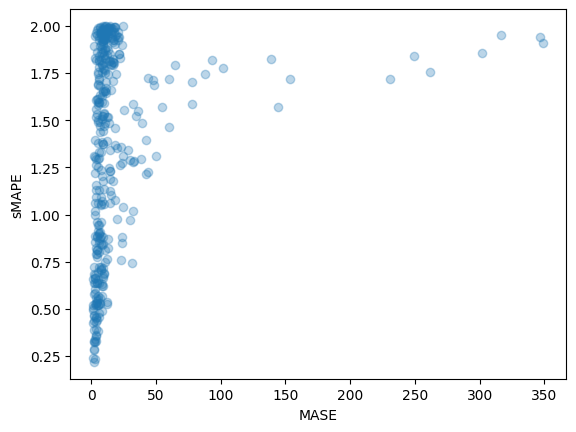

In [97]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [102]:
# Plot
def plot(ts_index):
    fig, ax = plt.subplots()
    
    index = pd.period_range(
        start = test_dataset[ts_index][FieldName.START],
        periods = len(test_dataset[ts_index][FieldName.TARGET]),
        freq = freq,
    ).to_timestamp()
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    ax.plot(
        index[-2*prediction_length:],
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label = "actual",
    )
    
    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label = "median"
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

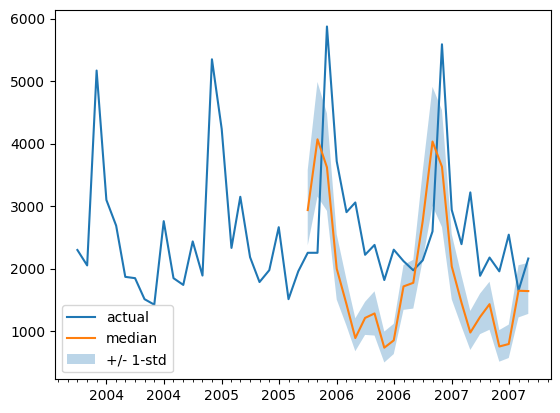

In [103]:
plot(334)

# Fim